# Tutorial: how to generate power-law surrogates


This notebook is designed very briefly to illustrate generation of different types of power-law surrogates from synthetic data and an empirical time series.

## Import source code and basic libraries

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import sys
# 
sys.path.append("../src/")
from constrained_power_law_surrogates import gen_typ_p_l_surrogate, gen_power_law_surr_list, ident_cut_off_const, estim_scale_exp, calc_ks_stat, cond_entropy_o_n

## Define functions

In [2]:
def plot_surr_seq(surr_seq, obs_seq=[], method_name=[], ax=[], x_label='Time', y_label='Value'):
    N = len(surr_seq)
    if not method_name:
        method_name = 'Surrogate'
    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    if obs_seq:
        match_seq = [obs_seq[ii] if surr_seq[ii] == obs_seq[ii] else np.nan for ii in range(N)]
        ax.scatter(list(range(N)), obs_seq, marker='o')
        ax.scatter(list(range(N)), surr_seq, marker='o')
        ax.scatter(list(range(N)), match_seq, marker='o')
        leg_labels = ['Observed', method_name, 'Equal']
    else:
        leg_labels = [method_name]
        ax.scatter(list(range(N)), surr_seq, marker='o')
        leg_labels = [method_name]
    ax.set_yscale('log')
    ax.legend(labels=leg_labels, framealpha=0.5)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
#
def ks_stat(seq):
    x_min = min(seq)
    gamma_m_l = estim_scale_exp(seq, x_min)
    return calc_ks_stat(seq, x_min, gamma_m_l)
#
def cond_ent_o_1(seq):
    return cond_entropy_o_n(seq, 1)
#
def cond_ent_o_2(seq):
    return cond_entropy_o_n(seq, 2)
# 
def hypothesis_test(obs_seq, method='cons', num_surr = 19, scale_exp=2.5, b=3, o=1, L=2, num_trans=10**5, stat_func_list=[ks_stat]):
    x_min = min(obs_seq)
    surr_seq_list = gen_power_law_surr_list(seq, surr_method=method, x_min=x_min, num_surr=num_surr, scale_exp=scale_exp, b=b, o=o, L=L, num_trans=num_trans)
    quantile_list = []
    p_val_left_tail_list = []
    p_val_right_tail_list = []
    p_val_two_tail_list = []
    print("Using surrogate method: " + str(method) + ':')
    print("Equating lower cut-off parameter *x_min* with minimum value of argument *obs_seq*: x_min*=" + str(x_min))
    for stat_func in stat_func_list:#Iterate over discriminating statistics
        print("\t With statistic: " + stat_func.__name__ + ":")
        #Calculate values of discrimintating statistic for observed sequence and surrogate sequences:
        obs_stat = stat_func(obs_seq)
        stat_val_surr_list = [stat_func(surr_seq) for surr_seq in surr_seq_list]
        #Add small random perturbations to avoid ties:
        abs_obs_stat = abs(obs_stat)
        obs_stat = obs_stat + 10**-6*abs_obs_stat*(np.random.uniform(size=1) - 0.5)
        stat_val_surr_list = [stat_val_surr + 10**-6*abs_obs_stat*(np.random.uniform(size=1) - 0.5) for stat_val_surr in stat_val_surr_list]#Add small random perturbations to avoid ties
        stat_val_surr_list = np.array(stat_val_surr_list)
        #Work out rank of observed statistic (position of statistic corresponding to observed sequence when statistics corresponding to observed sequence and surrogate sequences are ranked from smallest to largest)
        rankMin = 1 + sum(stat_val_surr_list < obs_stat)
        rankMax = 1 + sum(stat_val_surr_list <= obs_stat)
        r = random.randint(rankMin, rankMax)
        q = (r - 0.5)/(num_surr + 1)
        quantile_list = quantile_list + [q]
        p_left = q
        p_val_left_tail_list = p_val_left_tail_list + [p_left]
        p_right = 1 - q
        p_val_right_tail_list = p_val_right_tail_list + [p_right]
        p_two = 2*min([p_left, p_right])
        p_val_two_tail_list = p_val_two_tail_list + [p_two]
        print("\t\t Quantile: " + str(q))
        print("\t\t p-value for left-tailed test: " + str(p_left))
        print("\t\t p-value for right-tailed test: " + str(p_right))
        print("\t\t p-value for two-sided test: " + str(p_two))
    return quantile_list, p_val_left_tail_list, p_val_right_tail_list, p_val_two_tail_list

## Input sequence

Store your input sequence in the variable *seq*

Read input sequence *seq* from data

In [3]:
seqtext = open("../time-series/words.txt").read().split("\n")#Counts of distinct words in Moby Dick by Herman Melville:
seq = [int(x) for x in seqtext[:32]]
print(seq)

[14086, 6414, 6260, 4573, 4484, 4040, 2917, 2483, 2374, 1942, 1792, 1744, 1711, 1683, 1674, 1604, 1581, 1493, 1372, 1297, 1161, 1134, 1065, 1043, 1041, 1035, 1022, 897, 882, 844, 777, 770]


Alternatively, generate input sequence *seq* from a power-law with chosen exponent *gamma* and lower cut-off *x_min*:

In [4]:
gamma = 2; x_min = 3; N = 16;
seq = gen_typ_p_l_surrogate(gamma, x_min, N)
print(seq)

[10, 3, 3, 4, 4, 5, 3, 4, 3, 5, 9, 4, 5, 4, 30, 17]


## Estimating and applying the lower cut-off *x_min*

Estimate lower cut-off *x_min* by minimising KS-distance from maximum likelihood power-law

In [5]:
(x_min_KS, _, _, _, _) = ident_cut_off_const(seq)
print("Identified lower cut-off: " + str(x_min_KS))

Identified lower cut-off: 3


Divide input sequence *seq* into values *seq_L* below lower cut-off *x_min* and values *seq_U* greater than or equal to lower cut-off *x_min*

In [6]:
seq_L = [int(np.round(val)) for val in seq if val < x_min_KS]
print(seq_L)
seq_U = [int(np.round(val)) for val in seq if val >= x_min_KS]
print(seq_U)

[]
[10, 3, 3, 4, 4, 5, 3, 4, 3, 5, 9, 4, 5, 4, 30, 17]


## Surrogate methods

### This is a list and brief description of the methods to generate (surrogate) time series

In [7]:
surrogate_methods = ['obse','know','cons','typi','boot','shuf','mark','ordi']
method_description={
    'obse':'Original observation',
    'know':'Power-law surrogate with known scale exponent',
    'cons':'Constrained power-law surrogate',
    'typi':'Typical power-law surrogate',
    'boot':'Bootstrap surrogate',
    'shuf':'Shuffle surrogate',
    'mark':'Constrained Markov order power-law surrogate',
    'ordi':'Constrained ordinal pattern power-law surrogate',
    'unknown':'Unknown input method surrogate'
}
method_names = {
    'obse':'Observed',
    'know': 'Known exponent',
    'cons':'Constrained',
    'typi':'Typical',
    'boot':'Bootstrapped',
    'shuf':'Shuffled',
    'mark':'Markov',
    'ordi':'Ordinal pattern',
    'unknown':'Unknown'
}

You can choose one of the methods to generate the surrogate of the input sequence *seq* as:

In [8]:
print("Using sequence seq_U comprising values of input sequence above estimated lower cut-off x_min_KS=" + str(x_min_KS))
surr_seq_list = gen_power_law_surr_list(seq_U, surr_method='cons', x_min=x_min_KS)
print(surr_seq_list)

print("Using full input sequence seq and true lower cut-off x_min=" + str(x_min))
surr_seq_list = gen_power_law_surr_list(seq, surr_method='cons', x_min=x_min)
print(surr_seq_list)

Using sequence seq_U comprising values of input sequence above estimated lower cut-off x_min_KS=3
[[5, 9, 9, 4, 4, 5, 3, 4, 3, 10, 3, 4, 10, 4, 5, 17]]
Using full input sequence seq and true lower cut-off x_min=3
[[5, 3, 3, 4, 4, 15, 6, 4, 3, 5, 9, 4, 5, 4, 10, 17]]


Here are surrogates from all the methods:

In [9]:
for method in surrogate_methods:
    print("Using method: " + method + " to generate: " + method_description[method])
    if (method == 'know'):#Power-law surrogates with known scale exponent
        surr_seq_list = gen_power_law_surr_list(seq, surr_method=method, x_min=x_min, num_surr=2, scale_exp=2)#num_surr=2 independently realised surrogates, scale exponent 2
    elif (method == 'mark'):#Constrained Markov order power-law surrogate
        surr_seq_list = gen_power_law_surr_list(seq, surr_method=method, x_min=x_min, num_surr=2, o=1, b=3, num_trans=10**5)#num_surr=2 independently realised surrogates, Markov order o=1 using Markov states defined using bins of logarithmic length log(b) = log(3), Metropolis algorithm with num_trans=10**5 transitions
    elif (method == 'ordi'):#Constrained ordinal pattern power-law surrogate
        surr_seq_list = gen_power_law_surr_list(seq, surr_method=method, x_min=x_min, num_surr=2, L=16, num_trans=10**5)#num_surr=2 independently realised surrogates, Ordinal patterns of length L=16, Metropolis algorithm with num_trans=10**5 transitions
    else:
        surr_seq_list = gen_power_law_surr_list(seq, surr_method=method, x_min=x_min, num_surr=2)#num_surr=2 independently realised surrogates
    print(surr_seq_list,"\n")

Using method: obse to generate: Original observation
[[10, 3, 3, 4, 4, 5, 3, 4, 3, 5, 9, 4, 5, 4, 30, 17], [10, 3, 3, 4, 4, 5, 3, 4, 3, 5, 9, 4, 5, 4, 30, 17]] 

Using method: know to generate: Power-law surrogate with known scale exponent
[[3, 3, 3, 3, 7, 5, 6, 22, 5, 7, 5, 6, 4, 7, 5, 3], [31, 27, 5, 4, 28, 6, 15, 7, 4, 6, 5, 3, 331, 3, 3, 7]] 

Using method: cons to generate: Constrained power-law surrogate
[[10, 3, 3, 4, 4, 5, 27, 4, 3, 5, 3, 8, 5, 4, 5, 17], [15, 3, 3, 4, 4, 5, 3, 4, 3, 15, 3, 4, 5, 4, 10, 34]] 

Using method: typi to generate: Typical power-law surrogate
[[4, 3, 3, 5, 3, 3, 3, 3, 12, 4, 4, 3, 18, 5, 3, 14], [4, 120, 10, 3, 3, 464, 11, 4, 4, 58, 50, 4, 4, 4, 4, 3]] 

Using method: boot to generate: Bootstrap surrogate
[[4, 4, 5, 3, 3, 30, 4, 3, 5, 5, 3, 30, 17, 4, 5, 5], [3, 4, 5, 4, 30, 4, 4, 9, 17, 30, 4, 3, 30, 30, 17, 5]] 

Using method: shuf to generate: Shuffle surrogate
[[3, 4, 4, 10, 4, 5, 5, 9, 17, 3, 3, 4, 4, 5, 3, 30], [3, 3, 4, 5, 10, 30, 4, 3, 17, 4, 

### Plotting

Here is how to make plots comparing surrogates with the originally observed sequence:

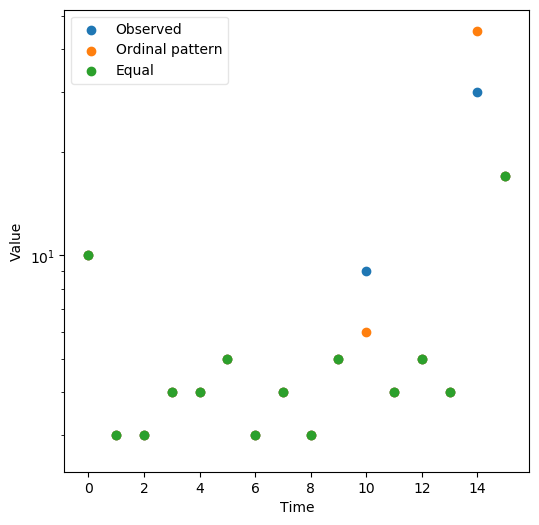

In [10]:
plot_surr_seq(surr_seq_list[0], obs_seq=seq, method_name=method_names[method], x_label='Time', y_label='Value')
plt.show()

### Hypothesis testing

Here is how to perform hypothesis tests

In [11]:
quantile_list, p_val_left_tail_list, p_val_right_tail_list, p_val_two_tail_list = hypothesis_test(seq_U, method='typi', stat_func_list=[ks_stat, np.mean, max, cond_ent_o_2], num_surr=99)
# 
print('\n Outputs of the function "hypothesis_test":')
print("\t quantile_list=" + str(quantile_list))
print("\t p_val_left_tail_list=" + str(p_val_left_tail_list))
print("\t p_val_right_tail_list=" + str(p_val_right_tail_list))
print("\t p_val_two_tail_list=" + str(p_val_two_tail_list))

Using surrogate method: typi:
Equating lower cut-off parameter *x_min* with minimum value of argument *obs_seq*: x_min*=3
	 With statistic: ks_stat:
		 Quantile: 0.465
		 p-value for left-tailed test: 0.465
		 p-value for right-tailed test: 0.5349999999999999
		 p-value for two-sided test: 0.93
	 With statistic: mean:
		 Quantile: 0.515
		 p-value for left-tailed test: 0.515
		 p-value for right-tailed test: 0.485
		 p-value for two-sided test: 0.97
	 With statistic: max:
		 Quantile: 0.545
		 p-value for left-tailed test: 0.545
		 p-value for right-tailed test: 0.45499999999999996
		 p-value for two-sided test: 0.9099999999999999
	 With statistic: cond_ent_o_2:
		 Quantile: 0.515
		 p-value for left-tailed test: 0.515
		 p-value for right-tailed test: 0.485
		 p-value for two-sided test: 0.97

 Outputs of the function "hypothesis_test":
	 quantile_list=[0.465, 0.515, 0.545, 0.515]
	 p_val_left_tail_list=[0.465, 0.515, 0.545, 0.515]
	 p_val_right_tail_list=[0.5349999999999999, 0.485, 0

## Illustration using empirical data

### Load empirical data from text file

Read input sequence *seq* from sequences of energy released by earthquakes:

In [12]:
seqtext = open("../time-series/energy.txt").read().split("\n")
seq = [int(x) for x in seqtext[:-1]]
print("Input sequence seq has length N=" + str(len(seq)))

Input sequence seq has length N=59555


### Estimate and apply the lower cut-off *x_min*

Estimate lower cut-off *x_min* by minimising KS-distance from maximum likelihood power-law

In [13]:
(x_min, _, _, _, _) = ident_cut_off_const(seq)
print("Identified lower cut-off x_min=" + str(x_min_KS))

Identified lower cut-off x_min=3


Discard elements of input sequence *seq* which lie below the estimated lower cut-off *x_min*

In [14]:
seq = [int(np.round(val)) for val in seq if val >= x_min]
print("After discarding elements less than the estimated lower cut-off x_min = " + str(x_min) + ", input sequence seq has length N=" + str(len(seq)))

After discarding elements less than the estimated lower cut-off x_min = 1, input sequence seq has length N=59555


### Make sequence shorter (for convenience)

Replace input sequence *seq* with a shorter contiguous subsequence

In [15]:
N = 1024# Maximum length of time series
N0 = len(seq)
if (N0 >= N):
    start_point = random.randint(0, N0 - N)
    seq = seq[start_point:(start_point + N)]
else:
    N = N0

print("Considering N=" + str(N) + " elements starting from randomly chosen index " + str(start_point))
print("Input sequence seq has length N=" + str(len(seq)))

Considering N=1024 elements starting from randomly chosen index 50887
Input sequence seq has length N=1024


### Visually compare surrogate sequences and original observations

Make plots comparing surrogates with the originally observed sequence of energy release by earthquakes

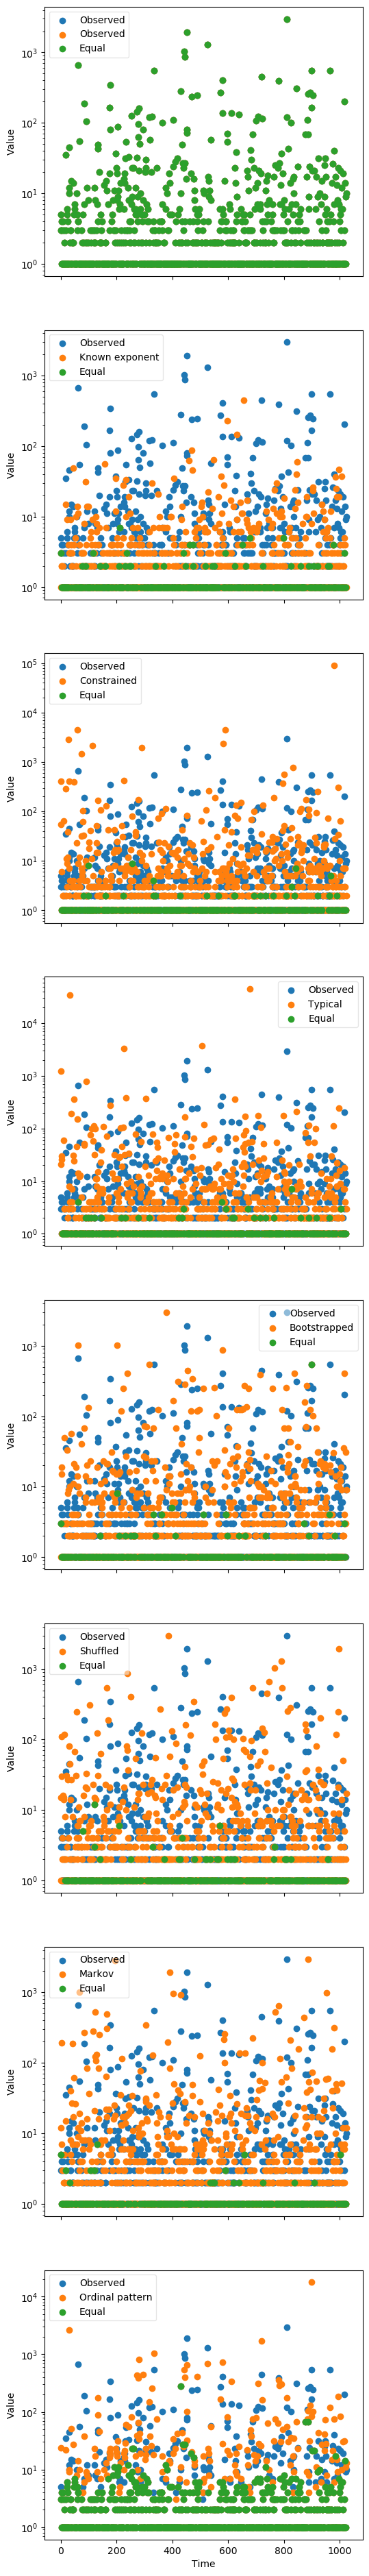

In [16]:
#Generate and plot realisation of each type of surrogate
num_surr_types = len(surrogate_methods)
fig, ax = plt.subplots(num_surr_types, 1, sharex='col', sharey='none', figsize=(6, 6*num_surr_types))
for i in range(num_surr_types):
    method = surrogate_methods[i]
    if (method == 'know'):#Power-law surrogates with known scale exponent
        surr_seq_list = gen_power_law_surr_list(seq, surr_method=method, x_min=x_min, scale_exp=2)#Scale exponent 2
    elif (method == 'mark'):#Constrained Markov order power-law surrogate
        surr_seq_list = gen_power_law_surr_list(seq, surr_method=method, x_min=x_min, o=1, b=3, num_trans=10**5)#Markov order o=1 using Markov states defined using bins of logarithmic length log(b) = log(3), Metropolis algorithm with num_trans=10**5 transitions
    elif (method == 'ordi'):#Constrained ordinal pattern power-law surrogate
        surr_seq_list = gen_power_law_surr_list(seq, surr_method=method, x_min=x_min, L=16, num_trans=10**5)#Ordinal patterns of length L=16, Metropolis algorithm with num_trans=10**5 transitions
    else:
        surr_seq_list = gen_power_law_surr_list(seq, surr_method=method, x_min=x_min)#
    surr_seq = surr_seq_list[0]
    ax_subplot = ax[i]
    plot_surr_seq(surr_seq, obs_seq=seq, method_name=method_names[method], ax=ax_subplot, x_label=None, y_label='Value')
ax[-1].set_xlabel('Time')
plt.show()

### Hypothesis testing

Perform hypothesis tests on extract of energy released by earthquakes

In [17]:
#Generate and plot realisation of each type of surrogate
stat_func_list = [ks_stat, np.mean, np.var, max, cond_ent_o_1, cond_ent_o_2]
num_surr_types = len(surrogate_methods)
fig, ax = plt.subplots(num_surr_types, 1, sharex='col', sharey='none', figsize=(6, 6*num_surr_types))
for i in range(num_surr_types):
    method = surrogate_methods[i]
    if (method == 'know'):#Power-law surrogates with known scale exponent
        quantile_list, p_val_left_tail_list, p_val_right_tail_list, p_val_two_tail_list = hypothesis_test(seq, method=method, stat_func_list=stat_func_list, num_surr=99, scale_exp=2)#Scale exponent 2
    elif (method == 'mark'):#Constrained Markov order power-law surrogate
        quantile_list, p_val_left_tail_list, p_val_right_tail_list, p_val_two_tail_list = hypothesis_test(seq, method=method, stat_func_list=stat_func_list, o=1, b=3, num_trans=10**5)#Markov order o=1 using Markov states defined using bins of logarithmic length log(b) = log(3), Metropolis algorithm with num_trans=10**5 transitions
    elif (method == 'ordi'):#Constrained ordinal pattern power-law surrogate
        quantile_list, p_val_left_tail_list, p_val_right_tail_list, p_val_two_tail_list = hypothesis_test(seq, method=method, stat_func_list=stat_func_list, L=16, num_trans=10**5)#Ordinal patterns of length L=16, Metropolis algorithm with num_trans=10**5 transitions
    else:
        quantile_list, p_val_left_tail_list, p_val_right_tail_list, p_val_two_tail_list = hypothesis_test(seq, method=method, stat_func_list=stat_func_list)#

Using surrogate method: obse:
Equating lower cut-off parameter *x_min* with minimum value of argument *obs_seq*: x_min*=1
	 With statistic: ks_stat:
		 Quantile: 0.675
		 p-value for left-tailed test: 0.675
		 p-value for right-tailed test: 0.32499999999999996
		 p-value for two-sided test: 0.6499999999999999
	 With statistic: mean:
		 Quantile: 0.375
		 p-value for left-tailed test: 0.375
		 p-value for right-tailed test: 0.625
		 p-value for two-sided test: 0.75
	 With statistic: var:
		 Quantile: 0.625
		 p-value for left-tailed test: 0.625
		 p-value for right-tailed test: 0.375
		 p-value for two-sided test: 0.75
	 With statistic: max:
		 Quantile: 0.675
		 p-value for left-tailed test: 0.675
		 p-value for right-tailed test: 0.32499999999999996
		 p-value for two-sided test: 0.6499999999999999
	 With statistic: cond_ent_o_1:
		 Quantile: 0.775
		 p-value for left-tailed test: 0.775
		 p-value for right-tailed test: 0.22499999999999998
		 p-value for two-sided test: 0.449999999999

		 Quantile: 0.425
		 p-value for left-tailed test: 0.425
		 p-value for right-tailed test: 0.575
		 p-value for two-sided test: 0.85
	 With statistic: mean:
		 Quantile: 0.075
		 p-value for left-tailed test: 0.075
		 p-value for right-tailed test: 0.925
		 p-value for two-sided test: 0.15
	 With statistic: var:
		 Quantile: 0.025
		 p-value for left-tailed test: 0.025
		 p-value for right-tailed test: 0.975
		 p-value for two-sided test: 0.05
	 With statistic: max:
		 Quantile: 0.025
		 p-value for left-tailed test: 0.025
		 p-value for right-tailed test: 0.975
		 p-value for two-sided test: 0.05
	 With statistic: cond_ent_o_1:
		 Quantile: 0.775
		 p-value for left-tailed test: 0.775
		 p-value for right-tailed test: 0.22499999999999998
		 p-value for two-sided test: 0.44999999999999996
	 With statistic: cond_ent_o_2:
		 Quantile: 0.825
		 p-value for left-tailed test: 0.825
		 p-value for right-tailed test: 0.17500000000000004
		 p-value for two-sided test: 0.3500000000000001
